In this blog post I will explain a problem we encounter in observational cosmology called photometric redshifts and how we can use Mixture Density Networks (MDN's) to solve them with an implementation in TensorFlow. MDN's are just a different flavour of Neural Network. MDN's in the [paper (PDF)](http://research.microsoft.com/en-us/um/people/cmbishop/downloads/Bishop-NCRG-94-004.pdf) by Bishop are applied to a toy problem trying to infer the position of a robotic arm. In this blog post I wanted to show the usage of MDN's on a real world problem, and with a real world problem I mean a simulated galaxy data set.
The code used in this work is based on the [second](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/) of Itoro's comprehensive  blog posts on MDN's, the first one uses theano and can be found [here](http://blog.otoro.net/2015/06/14/mixture-density-networks/). 

If you are a machine learning researcher or enthusiast I hope you can learn a bit about a challenging astronomy problem and maybe you can help me answer some ML question I have posed at the end of this blog. If you work with noisy data and/or just  you want full probability density functions (PDF's) I hope  you might be able to apply MDN's to your work. If you're not convinced on why you might want a full PDF have a look at this [excellent post on utility functions](http://www.sumsar.net/blog/2015/01/probable-points-and-credible-intervals-part-two/) by Rasmus Bååth on the need for PDF's for better decision making.

If you are completely new to TensorFlow have a look at the following (free online) book: [First contact with TensorFlow](http://www.jorditorres.org/first-contact-with-tensorflow-book/) by [Jordi Torres](http://www.jorditorres.org/), I helped out with the translation from the original Spanish version. If you have no idea about neural nets and TensorFlow, this a very gentle introduction.

This blog post is written in a [jupyter notebook](https://github.com/cbonnett/blog/blob/master/content/Mixture%20Density%20Networks%20for%20Galaxy%20distance%20determination%20in%20TensorFlow%20.ipynb) and the data used can be downloaded: [train data](https://drive.google.com/file/d/0B6Mi26c8VkJadFlaVEJObWw3WTg/view?usp=sharing) [test data](https://drive.google.com/file/d/0B6Mi26c8VkJaTE5DVFdZTE9SWmM/view?usp=sharing).

## The photometric redshift problem:

In short, we want determine the distances to galaxies using just a few noisy features. The photometric redshift problem happens to be a inverse problem with heteroscedastic noise properties. Hello ? Are you still here ? Great ! Heteroscedastic means that the noise properties of the data is not constant. Another way of saying this is that the variability of properties varies within the sample. The inverse part refers to the fact that there are more that one likely solution to the problem, hence the answer might be multimodal. 
Btw, we will refer to the distance of a galaxy as [redshift](https://en.wikipedia.org/wiki/Redshift). This is due to the fact that we live in an expanding universe, hence galaxies that are further away are moving faster away from us and as the galaxies move away from each other the frequency of the light viewed here on earth is shifted towards the red side of the spectrum. So by measuring their spectrum we can measure the redshift and thus the distance. The effect is similar to the doppler shift. This information is not crucial for understand the rest of this blog, but pretty cool, so do yourself a favor and read that wiki page.    

Due to nature of the galaxies and due to the noise properties it can happen that a galaxy that is close by (i.e low redshift) looks like a different kind of galaxy that is far away (i.e high redshift) and with the limited features we can measure we have no idea of knowing which it is. So we are interested in estimating the probability density function of the redshift for the galaxies and using MDN's is one possible way of doing so.  

You might be wondering why we need the distances to the galaxies, in my case it is to measure the accelerated expansion of the universe a.k.a [Dark Energy](https://en.wikipedia.org/wiki/Dark_energy), and to be more exact I would like to infer the redshift distribution of an ensemble of galaxies. Other astronomer might want to use it other purposes.

The redshift of a galaxy can be measured exactly with a spectrograph. A spectrograph will detect emission lines in the spectrum of the galaxy that allows to precisely determine the redshift. The problem with spectrographs is that the use is expensive in time, meaning you can not observe massive amount of galaxies with them. 
To be able to measure the properties of massive amount of galaxies (100 million+) we perform photometric surveys, these use large CCD cameras to take images of the sky in several filters. In the following image, the blue, green and red line is the spectrum of a galaxy at different redshifts. With a spectrograph one can measure exact details of these lines and hence the redshift. The 5 grey areas on bottom are the filter response curves used in photometric surveys. This means that in the photometric survey we measure 5 values, one for each of the filters. The measurement are referred to as magnitudes (which happens to be the negative of a log transform of the flux thus high magnitude means a faint galaxy).  
As you can see the detailed information of the spectrum of galaxies is lost when using the photometric information, the advantage is that we can observe many more galaxies. But now the problem is that we have to infer the redshift of the galaxies with just those 5 numbers, and as you probably can see from the image, it's not going to be easy.
![Alt Text](./images/plot_sdss_filters_2.png)
This image is taken from the [astroML](http://www.astroml.org/#astroml-machine-learning-and-data-mining-for-astronomy) page that accompanies the excellent book: [Statistics, Data Mining, and Machine Learning in Astronomy](http://www.astroml.org/#textbook)

To make things more complicated the noise levels within the data sets differ quite significantly, this can be due to that some parts of the sky have been observed with longer exposure times, but even for galaxies with the same amount of exposure time the noise levels will differ based on the brightness and size of the galaxy and on the amount of turbulence in the atmosphere while observing. The good news is that for each of the 5 magnitudes (i.e features) we can also estimate the noise of this measurement, this leaves us with 5 measured magnitudes accompanied with an error estimate totalling to 10 features (we are assuming the noise is not correlated which is a simplification).

Just to recap, from a machine learning standpoint we have the following problem, we have a large data set for which  we have measured 5 magnitudes and their respective errors, a subset of these galaxies have also been observed with a spectrograph and hence we know the exact redshift. We want to predict the redshift, so we have a regression  problem, but we are not just interested in the most likely redshift but in the full PDF.

## Mixture Density Networks
This is where MDN's come in, MDN's are very similar to standard Neural Networks with the only difference being that final layer is mapped to a mixture of distributions. This makes them an elegant solution for modeling arbitrary conditional probability distributions like we have here. 
In our case : $$ p(z \hspace{1mm} | \hspace{1mm} x) = \sum_{k=1}^{K} \pi_k(x) Beta(z |\alpha_k(x), \beta_{k}(x))$$
where z is redshift and x are the measured features with their corresponding errors. 
So the output of a MDN is $k$ mixture components and the parameters for each of the $k$ distributions. In our case we will be using a mixture of $Beta$ distributions as it suits the purpose of our problem. 
Here is a little recap on what shape the $Beta$ distribution can take.

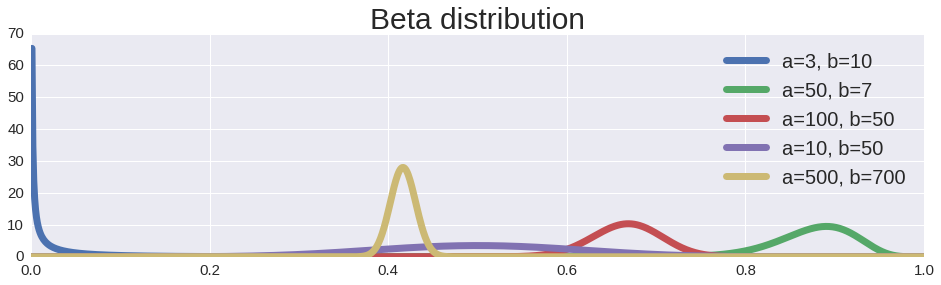

In [2]:
%matplotlib inline
from __future__ import division
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

x = np.linspace(0.0, 1.0, 1000)
b0 = beta.pdf(x, 0.1 , 10)
b1 = beta.pdf(x, 50 , 7)
b2 = beta.pdf(x, 100 , 50)
b3 = beta.pdf(x, 10 , 10)
b4 = beta.pdf(x, 500 , 700)
plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x, b0, label='a=3, b=10', lw=7)
plt.plot(x, b1, label='a=50, b=7' ,lw=7)
plt.plot(x, b2, label='a=100, b=50', lw=7)
plt.plot(x, b3, label='a=10, b=50', lw=7)
plt.plot(x, b4, label='a=500, b=700', lw=7)
plt.legend(fontsize=20)
plt.title('Beta distribution', fontsize=30)

## The data set
In this blog post we will use a simulated galaxy data set. This data set contains galaxies that have been simulated with 5 different exposures times, ranging from very high signal to noise (S/N) to very low S/N. Keep in mind, as mentioned earlier, even within a fixed exposure time we have varying noise levels. A training sample has already been created with 30000 fairly sampled galaxies for each exposure time leading to a total of 150000 galaxies in the training set. The validation set contains 75000 galaxies and we have the 5 exposure levels and the true magnitudes for each of those galaxies so we can look at the influence of the noise on the prediction. Let's read in the data and explore the data set. In astronomy is the convention that filters have a letter as a name, in this case we have $g,r,i,z,Y$ as the 5 measured magnitudes, these are the filters used in the [Dark Energy Survey](http://www.darkenergysurvey.org/).

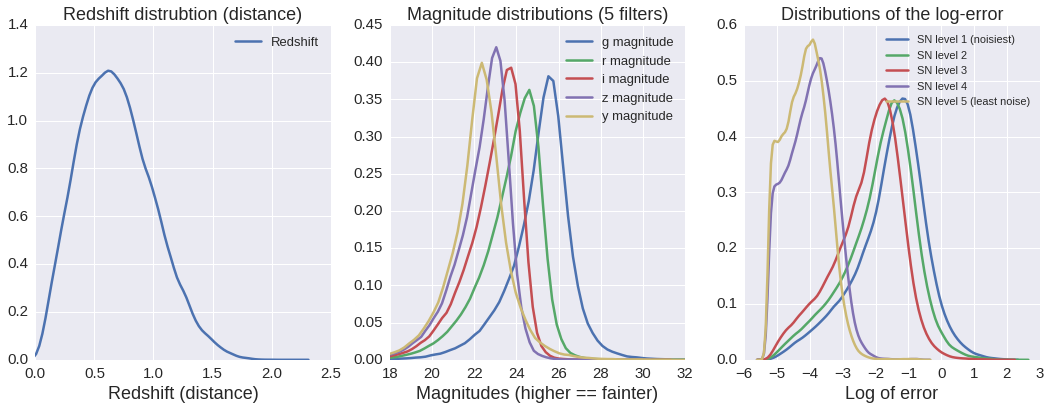

In [3]:
import pandas as pd
df_train = pd.read_csv('./data/galaxy_redshift_sims_train.csv', 
                       engine='c', na_filter=False, nrows=150000) 
df_valid = pd.read_csv('./data/galaxy_redshift_sims_valid.csv', 
                       engine='c', na_filter=False, nrows=75000)

### a hack to so that valid loss does not return a NaN
df_valid = df_valid[(df_valid.redshift < df_train.redshift.max()) & 
                    (df_valid.redshift > df_train.redshift.min())]


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
sns.distplot(df_valid.redshift, kde=True, ax=axes[0], hist=False, label='Redshift')
axes[0].set_xlim([0, 2.5])
axes[0].set_title('Redshift distrubtion (distance)', fontsize=18)
axes[0].legend(fontsize=13)
axes[0].set_xlabel('Redshift (distance)', fontsize=18)

sns.distplot(df_valid.g_SN_1, kde=True,ax=axes[1], hist=False, label='g magnitude')
sns.distplot(df_valid.r_SN_1, kde=True,ax=axes[1], hist=False, label='r magnitude')
sns.distplot(df_valid.i_SN_1, kde=True,ax=axes[1], hist=False, label='i magnitude')
sns.distplot(df_valid.z_SN_1, kde=True,ax=axes[1], hist=False, label='z magnitude')
sns.distplot(df_valid.y_SN_1, kde=True,ax=axes[1], hist=False, label='y magnitude')
axes[1].set_xlim([18, 32])
axes[1].set_title('Magnitude distributions (5 filters)', fontsize=18)
axes[1].legend(fontsize=13)
axes[1].set_xlabel('Magnitudes (higher == fainter)', fontsize=18)

sns.distplot(df_valid.log_g_err_SN_1, kde=True,ax=axes[2], hist=False, 
             label='SN level 1 (noisiest)')
sns.distplot(df_valid.log_g_err_SN_2, kde=True,ax=axes[2], hist=False, 
             label='SN level 2')
sns.distplot(df_valid.log_g_err_SN_3, kde=True,ax=axes[2], hist=False, 
             label='SN level 3')
sns.distplot(df_valid.log_g_err_SN_4, kde=True,ax=axes[2], hist=False, 
             label='SN level 4')
sns.distplot(df_valid.log_g_err_SN_5, kde=True,ax=axes[2], hist=False, 
             label='SN level 5 (least noise)')
axes[2].set_xlim([-6, 3])
axes[2].set_title('Distributions of the log-error', fontsize=18)
axes[2].legend(fontsize=11)
axes[2].set_xlabel('Log of error', fontsize=18)

In [4]:
df_train.head()

,g,g_err,r,r_err,i,i_err,z,z_err,y,y_err,redshift,log_g_err,log_r_err,log_i_err,log_z_err,log_y_err
0,22.561269,0.030931,20.784303,0.014176,19.952773,0.012864,19.536000,0.012374,19.335426,0.031846,0.5249,-3.475996,-4.256205,-4.353323,-4.392158,-4.392158
1,25.392476,0.212410,23.596781,0.090048,22.407283,0.051218,22.044526,0.073657,21.958519,0.287072,0.5844,-1.549237,-2.407412,-2.971664,-2.608336,-2.608336
2,23.455420,0.046455,21.957914,0.021684,21.527561,0.031701,21.105837,0.040076,21.078874,0.127973,0.4632,-3.069271,-3.831181,-3.451407,-3.216978,-3.216978
3,25.472922,0.289218,23.886281,0.092148,22.917807,0.090538,22.638243,0.123078,22.153964,0.312088,0.5558,-1.240575,-2.384359,-2.401986,-2.094937,-2.094937
4,23.598560,0.063078,22.290325,0.027985,21.883217,0.041042,21.607525,0.049119,21.211616,0.182087,0.4179,-2.763383,-3.576087,-3.193159,-3.013509,-3.013509


In [5]:
### In the validation set we have the 5 SN levels for each galaxy ###
df_valid.head()

,id,redshift,g_true,r_true,i_true,z_true,y_true,g_SN_5,g_err_SN_5,r_SN_5,...,log_g_err_SN_4,log_r_err_SN_4,log_i_err_SN_4,log_z_err_SN_4,log_y_err_SN_4,log_g_err_SN_5,log_r_err_SN_5,log_i_err_SN_5,log_z_err_SN_5,log_y_err_SN_5
0,1296052,0.4257,25.706,23.999,23.424,23.052,22.915,25.714726,0.023859,24.000923,...,-3.710634,-4.264421,-4.522025,-4.693892,-4.693892,-3.735594,-4.822456,-4.946112,-5.003411,-5.003411
1,522044,0.4798,24.595,22.802,22.065,21.670,21.518,24.595868,0.009302,22.801899,...,-4.369229,-4.722941,-4.964277,-5.076294,-5.076294,-4.677526,-5.146283,-5.192697,-5.196122,-5.196122
2,1596357,0.4903,26.480,24.917,24.318,23.984,23.845,26.483449,0.034660,24.907106,...,-2.836799,-3.500476,-3.938418,-4.122004,-4.122004,-3.362169,-4.370098,-4.518626,-4.618661,-4.618661
3,993122,0.2738,21.122,19.920,19.507,19.209,19.080,21.122545,0.005330,19.919980,...,-5.203735,-5.210673,-5.256216,-5.268370,-5.268370,-5.234404,-5.280085,-5.283035,-5.287377,-5.287377
4,1655575,0.9341,26.041,25.084,24.051,23.518,23.396,26.026716,0.020367,25.077148,...,-3.376407,-3.025017,-4.206797,-4.413971,-4.413971,-3.893839,-4.252122,-4.833703,-4.913463,-4.913463


The above plots and DataFrame heads should give you some idea on what the data set looks like. Lets extract the features and scale the parameters. Given that we are using noisy data we will use the RobustScaler in scikit-learn which is always advisable if you are dealing with noisy data. Given that we are using a mixture of $Beta$ distributions which is only valid for $0 \lt x \lt 1 $ we need to scale the redshift to this range.   

In [6]:
from sklearn.preprocessing import RobustScaler
RS = RobustScaler()

### The training features ### 
feat_train = ['g', 'log_g_err', 'r', 'log_r_err', 'i', 'log_i_err',
              'z', 'log_z_err', 'y', 'log_y_err']

### The features for the validation set, ###  ###
### each galaxy has 5 distinct features 1 for each exposer time ###
feat_SN_1 = ['g_SN_1', 'log_g_err_SN_1', 'r_SN_1', 'log_r_err_SN_1',
             'i_SN_1', 'log_i_err_SN_1', 'z_SN_1', 'log_z_err_SN_1',
             'y_SN_1', 'log_y_err_SN_1']

feat_SN_2 = ['g_SN_2', 'log_g_err_SN_2', 'r_SN_2', 'log_r_err_SN_2',
             'i_SN_2', 'log_i_err_SN_2', 'z_SN_2', 'log_z_err_SN_2',
             'y_SN_2', 'log_y_err_SN_2']

feat_SN_3 = ['g_SN_3', 'log_g_err_SN_3', 'r_SN_3', 'log_r_err_SN_3',
             'i_SN_3', 'log_i_err_SN_3', 'z_SN_3', 'log_z_err_SN_3',
             'y_SN_3', 'log_y_err_SN_3']

feat_SN_4 = ['g_SN_4', 'log_g_err_SN_4', 'r_SN_4', 'log_r_err_SN_4',
             'i_SN_4', 'log_i_err_SN_4', 'z_SN_4', 'log_z_err_SN_4',
             'y_SN_4', 'log_y_err_SN_4']

feat_SN_5 = ['g_SN_5', 'log_g_err_SN_5', 'r_SN_5', 'log_r_err_SN_5',
             'i_SN_5', 'log_i_err_SN_5', 'z_SN_5', 'log_z_err_SN_5',
             'y_SN_5', 'log_y_err_SN_5']

###  training features with robust scaler ###
X_train = RS.fit_transform(df_train[feat_train])

### validation features in different noise levels ###
X_valid_SN_1 = RS.transform(df_valid[feat_SN_1])
X_valid_SN_2 = RS.transform(df_valid[feat_SN_2])
X_valid_SN_3 = RS.transform(df_valid[feat_SN_3])
X_valid_SN_4 = RS.transform(df_valid[feat_SN_4])
X_valid_SN_5 = RS.transform(df_valid[feat_SN_5])

### The targets that we wish to learn ###
Y_train = df_train['redshift']
Y_valid = df_valid['redshift']

### Some scaling of the target between 0 and 1 ###
### so we can model it with a beta function ###
### given that Beta function is not defined ###
### at 0 or 1 I've come up with this ulgy hack ###
max_train_Y = Y_train.max() + 0.00001
min_train_Y = Y_train.min() - 0.00001

### scaling : 0 < target < 1 ###
Y_train = (Y_train - min_train_Y) / (max_train_Y - min_train_Y)
Y_valid = (Y_valid - min_train_Y) / (max_train_Y - min_train_Y)

Y_train = Y_train[:, np.newaxis]  # add extra axis as tensorflow expects this 
Y_valid = Y_valid[:, np.newaxis] 

For the validation set we also have the true magnitudes and not just the noisy draws, this allows us to make a 'artificial' validation set where we set the magnitude to the true magnitude but keep the error values.

In [7]:
### we will make a third test set    ###
### where magnitudes are set to the  ###
### true value but we keep the noise ###

feat_SN_1_artific = ['g_true', 'log_g_err_SN_1', 'r_true', 'log_r_err_SN_1',
                     'i_true', 'log_i_err_SN_1', 'z_true', 'log_z_err_SN_1',
                     'y_true', 'log_y_err_SN_1']

feat_SN_2_artific = ['g_true', 'log_g_err_SN_2', 'r_true', 'log_r_err_SN_2',
                     'i_true', 'log_i_err_SN_2', 'z_true', 'log_z_err_SN_2',
                     'y_true', 'log_y_err_SN_2']

feat_SN_3_artific = ['g_true', 'log_g_err_SN_3', 'r_true', 'log_r_err_SN_3',
                     'i_true', 'log_i_err_SN_3', 'z_true', 'log_z_err_SN_3',
                     'y_true', 'log_y_err_SN_3']

feat_SN_4_artific = ['g_true', 'log_g_err_SN_3', 'r_true', 'log_r_err_SN_3',
                     'i_true', 'log_i_err_SN_3', 'z_true', 'log_z_err_SN_3',
                     'y_true', 'log_y_err_SN_3']

feat_SN_5_artific = ['g_true', 'log_g_err_SN_3', 'r_true', 'log_r_err_SN_3',
                     'i_true', 'log_i_err_SN_3', 'z_true', 'log_z_err_SN_3',
                     'y_true', 'log_y_err_SN_3']

### validation features in different noise levels ###
X_valid_SN_1_artific = RS.transform(df_valid[feat_SN_1_artific])
X_valid_SN_2_artific = RS.transform(df_valid[feat_SN_2_artific])
X_valid_SN_3_artific = RS.transform(df_valid[feat_SN_3_artific])
X_valid_SN_4_artific = RS.transform(df_valid[feat_SN_4_artific])
X_valid_SN_5_artific = RS.transform(df_valid[feat_SN_5_artific])

Even though we have 5 different noise levels, the 3 noisiest are of highest interest (to me) as they more closely represent the realistic case. Within the next few years we are expected to observe 1/8 th of the entire sky with a signal to noise level that is in the ballpark of the 3 noisiest sets in this dataset. The very high signal to noise observations are only obtained in small areas of the sky where the observations are regularly repeated to do time-domain science, like finding supernovae. 

## MDN's in TensorFlow
In the next code block we will start building the MDN. We will model the PDF of a galaxy as a mixture 5 $Beta$ distributions. The neural network will figure out how many it actually needs and set the mixture components of the other close to zero, so adding extra complexity should not punish your predictive power, but you might of course be wasting computational resources. Limiting the amount of mixtures is also a way limiting the model complexity when you are worried about overfitting. The neural network that will be building will be a rather simple one, we are trying to learn a distribution, not translate Klingon to Elvish trained on screenshots and luck. We will make neural network with 3 hidden layers with 20, 20 and 10 neurons in each layer respectively. We will use the tanh activation function and no dropout regularization just some old-fashioned L2 regularization. I comment further on these choices at the end the blog (ReLU leads to NaN loss).

In [8]:
import tensorflow as tf
STDEV = 0.10
KMIX = 5  # number of mixtures
NOUT = KMIX * 3  # KMIX times a pi, alpha and beta

n_hidden_1 = 20  # 1st layer num neurons
n_hidden_2 = 20  # 2nd layer num neurons
n_hidden_3 = 10  # 2nd layer num neurons

# place holders
weight_decay = tf.placeholder(dtype=tf.float32, name="wd")
x = tf.placeholder(dtype=tf.float32, shape=[None, 10], name="x")
y = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="y")

# hidden layer one 
Wh = tf.Variable(tf.random_normal([10, n_hidden_1], stddev=STDEV, dtype=tf.float32))
bh = tf.Variable(tf.random_normal([1, n_hidden_1], stddev=STDEV, dtype=tf.float32))

# hidden layer two 
Wh2 = tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=STDEV, dtype=tf.float32))
bh2 = tf.Variable(tf.random_normal([1, n_hidden_2], stddev=STDEV, dtype=tf.float32))

# hidden layer three
Wh3 = tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3], stddev=STDEV, dtype=tf.float32))
bh3 = tf.Variable(tf.random_normal([1, n_hidden_3], stddev=STDEV, dtype=tf.float32))

# output layer
Wo = tf.Variable(tf.random_normal([n_hidden_3,NOUT], stddev=STDEV, dtype=tf.float32))
bo = tf.Variable(tf.random_normal([1, NOUT], stddev=STDEV, dtype=tf.float32))

## tanh acitivation function
hidden_layer1 = tf.nn.tanh(tf.add(tf.matmul(x, Wh), bh))
hidden_layer2 = tf.nn.tanh(tf.add(tf.matmul(hidden_layer1, Wh2),bh2))
hidden_layer3 = tf.nn.tanh(tf.add(tf.matmul(hidden_layer2, Wh3),bh3))

# # ReLU acitivation function
# hidden_layer1 = tf.nn.relu(tf.add(tf.matmul(x, Wh), bh))
# hidden_layer2 = tf.nn.relu(tf.add(tf.matmul(hidden_layer1, Wh2),bh2))
# hidden_layer3 = tf.nn.relu(tf.add(tf.matmul(hidden_layer2, Wh3),bh3))

output = tf.matmul(hidden_layer3, Wo) + bo

The parameters we want to predict are $k$ mixture components $\pi$ and the $\alpha$ and $\beta$ shape parameters for  each of the $k$ $Beta$ distributions. All three are subject to constraints:   

$$\sum_{n=1}^{k} \pi_{n} = 1 $$
$$\alpha, \beta > 0$$  

In the function in the following code block we transform the neurons of the final layer into the factors we can interpret as our parameters of interest. The first five outputs are mapped to the 5 mixing weights $\pi$ by putting them through a softmax transformation, this ensures they are positive and add to one, while the next five are mapped to the $\alpha's$ and the last five to the $\beta's$, by taking the exponential of those we can guarantee that they are positive as required.
Below is a schematic where the output is mapped to two $Beta$ distributions.

![ALt Text](./images/MDN_drawing_small.png)

In [9]:
def get_mixture_coef(output):
    ### Mapping output layer to mixute components and 
    ### parameters of the distribution
    out_pi = tf.placeholder(dtype=tf.float32, shape=[None, KMIX], name="mixparam")
    out_alpha = tf.placeholder(dtype=tf.float32, shape=[None, KMIX], name="mixparam")
    out_beta = tf.placeholder(dtype=tf.float32, shape=[None, KMIX], name="mixparam")

    ### split the last layer in 3 'blocks'
    out_pi, out_alpha, out_beta = tf.split(1, 3, output)

    ### sofmax transform out_pi
    max_pi = tf.reduce_max(out_pi, 1, keep_dims=True)
    out_pi = tf.sub(out_pi, max_pi)
    out_pi = tf.exp(out_pi)

    normalize_pi = tf.inv(tf.reduce_sum(out_pi, 1, keep_dims=True))
    out_pi = tf.mul(normalize_pi, out_pi)

    ### take exponetial of out_alpha and out_beta 
    ### to guarantee they are > 0.
    out_alpha = tf.exp(out_alpha)
    out_beta = tf.exp(out_beta)

    return out_pi, out_alpha, out_beta
out_pi, out_alpha, out_beta = get_mixture_coef(output) 

To be able to use of mixture of $Beta$ distributions we will have to implement the $Beta$ distribution in TensorFlow and to do so we will need the $Gamma$ distribution or $log-Gamma$ to be more precise. A fast approximation to the $log-Gamma$ to function can be found on [Paul Mineiro's blog](http://www.machinedlearnings.com/2011/06/faster-lda.html), with which we can build the $Beta$ distribution.

In [10]:
def gammaln(x):
    # fast approximate gammaln from Paul Mineiro
    # http://www.machinedlearnings.com/2011/06/faster-lda.html
    logterm = tf.log (x * (1.0 + x) * (2.0 + x))
    xp3 = 3.0 + x
    return -2.081061466 - x + 0.0833333 / xp3 - logterm + (2.5 + x) * tf.log (xp3)

def tf_beta_dist(y, s1, s2):
    # beta distribtution for tensorflow 
    exp1 = tf.sub(s1, 1.0)
    exp2 = tf.sub(s2, 1.0)
    d1 = tf.mul(exp1, tf.log(y))
    d2 = tf.mul(exp2, tf.log(tf.sub(1.0, y)))
    f1 = tf.add(d1, d2)
    f2 = gammaln(s1)      
    f3 = gammaln(s2)      
    f4 = gammaln(s1 + s2) 
    return  tf.exp(tf.add((tf.sub(f4, tf.add(f2, f3))),f1))

Having defined the $Beta$ distribution we can now define our loss function after which we will be ready to train the network. For regression problems one usually minimizes the squared error (L2 loss function), in this case however it makes more sense to minimize the negative log likelihood of the data. (Discretizing your regression problem and treating it as a classification problem is something you should consider if you are using a L2 loss function, i.e softmax regression)

In the case of homoscedastic errors it doesn't make much sense to feed the error as features as it the same for all
examples. In the case for heteroscedastic errors the error estimate actually contains some information of the target, but I expect the information to be of minimal importance compared to the measured feature. We can perform the following experiment:

Imagine a pathological case where you happen to observe the same galaxy at different noise levels, but the magnitude you measure is always the same (what are the odds ?). The most likely redshift for all these cases (naively) should be very similar, it is the uncertainty of how well we know this redshift that will differ to greater degree. We will be able to see if that is true later on. When you minimize the negative log-likelihood (or the cross-entropy) it makes sense to add the estimate of the noise as it contains the information on the uncertainty.

In [11]:
def get_lossfunc(out_pi, out_alpha, out_beta, y, Wh, Wh2, Wo, weight_decay=5e-4):
    ### neg log likelihood with L2 regularization
    result = tf_beta_dist(y, out_alpha, out_beta)
    result = tf.mul(result, out_pi)
    result = tf.reduce_sum(result, 1, keep_dims=True)
    result = -tf.log(result)
    regularizers = (tf.nn.l2_loss(Wh) + tf.nn.l2_loss(Wh2) + tf.nn.l2_loss(Wo)
                    +tf.nn.l2_loss(bh) + tf.nn.l2_loss(bh2) + tf.nn.l2_loss(bo))
    return tf.reduce_mean(result) + (weight_decay * regularizers)   

## Training the MDN
We are now ready to train the network on our data, let's take it for a spin !

In [12]:
NEPOCH = 10000
weight_decay_value = 0.00001
with tf.device('/gpu:0'):
    lossfunc = get_lossfunc(out_pi, out_alpha, out_beta, y, Wh, Wh2, Wo)
    train_op = tf.train.AdamOptimizer().minimize(lossfunc)
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, 
                                            log_device_placement=True))
    sess.run(tf.initialize_all_variables()) 

    loss_train   = np.zeros(NEPOCH) # store the training progress here.
    loss_valid_1 = np.zeros(NEPOCH)
    loss_valid_3 = np.zeros(NEPOCH)

    for i in range(NEPOCH):
        sess.run(train_op, feed_dict={x: X_train, 
                                      y: Y_train, 
                                      weight_decay: weight_decay_value})

        loss_train[i] = sess.run(lossfunc, feed_dict={x: X_train,
                                                      y: Y_train,
                                                      weight_decay: weight_decay_value})

        loss_valid_1[i] = sess.run(lossfunc, feed_dict={x: X_valid_SN_1,
                                                      y: Y_valid,
                                                      weight_decay: weight_decay_value})

        loss_valid_3[i] = sess.run(lossfunc, feed_dict={x: X_valid_SN_3,
                                                        y: Y_valid,
                                                        weight_decay: weight_decay_value})


    pi_1,alpha_1, beta_1 = sess.run(get_mixture_coef(output), 
                                    feed_dict={x: X_valid_SN_1})
    pi_2,alpha_2, beta_2 = sess.run(get_mixture_coef(output), 
                                    feed_dict={x: X_valid_SN_2})
    pi_3,alpha_3, beta_3 = sess.run(get_mixture_coef(output), 
                                    feed_dict={x: X_valid_SN_3})
    pi_4,alpha_4, beta_4 = sess.run(get_mixture_coef(output), 
                                    feed_dict={x: X_valid_SN_4})
    pi_5,alpha_5, beta_5 = sess.run(get_mixture_coef(output), 
                                    feed_dict={x: X_valid_SN_5})

    pi_1_a, alpha_1_a, beta_1_a = sess.run(get_mixture_coef(output), 
                                           feed_dict={x: X_valid_SN_1_artific})
    pi_2_a, alpha_2_a, beta_2_a = sess.run(get_mixture_coef(output), 
                                           feed_dict={x: X_valid_SN_2_artific})
    pi_3_a, alpha_3_a, beta_3_a = sess.run(get_mixture_coef(output), 
                                           feed_dict={x: X_valid_SN_3_artific})
    pi_4_a, alpha_4_a, beta_4_a = sess.run(get_mixture_coef(output), 
                                           feed_dict={x: X_valid_SN_4_artific})
    pi_5_a, alpha_5_a, beta_5_a = sess.run(get_mixture_coef(output), 
                                           feed_dict={x: X_valid_SN_5_artific})

sess.close()

We can see how the loss has evolved as function of time for 2 different signal to noise levels.

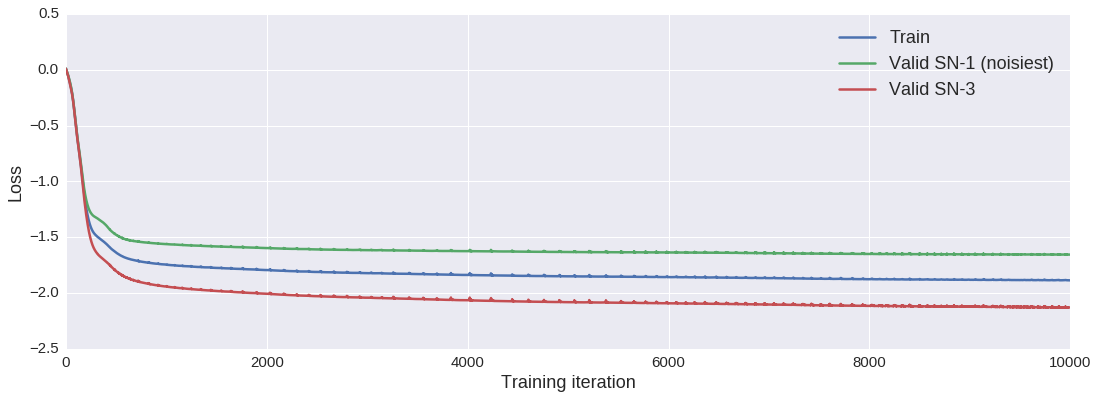

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))

axes.plot(np.arange(0, NEPOCH,1), (loss_train), label='Train')
axes.plot(np.arange(0, NEPOCH,1), (loss_valid_1), label='Valid SN-1 (noisiest)')
axes.plot(np.arange(0, NEPOCH,1), (loss_valid_3), label='Valid SN-3 ')
axes.set_xlabel('Training iteration',fontsize=18)
axes.set_ylabel('Loss', fontsize=18)
axes.legend(fontsize=18)

## Results
Let see how the mixture models performs for the same galaxy. I expect the noisiest to have the broadest PDF.

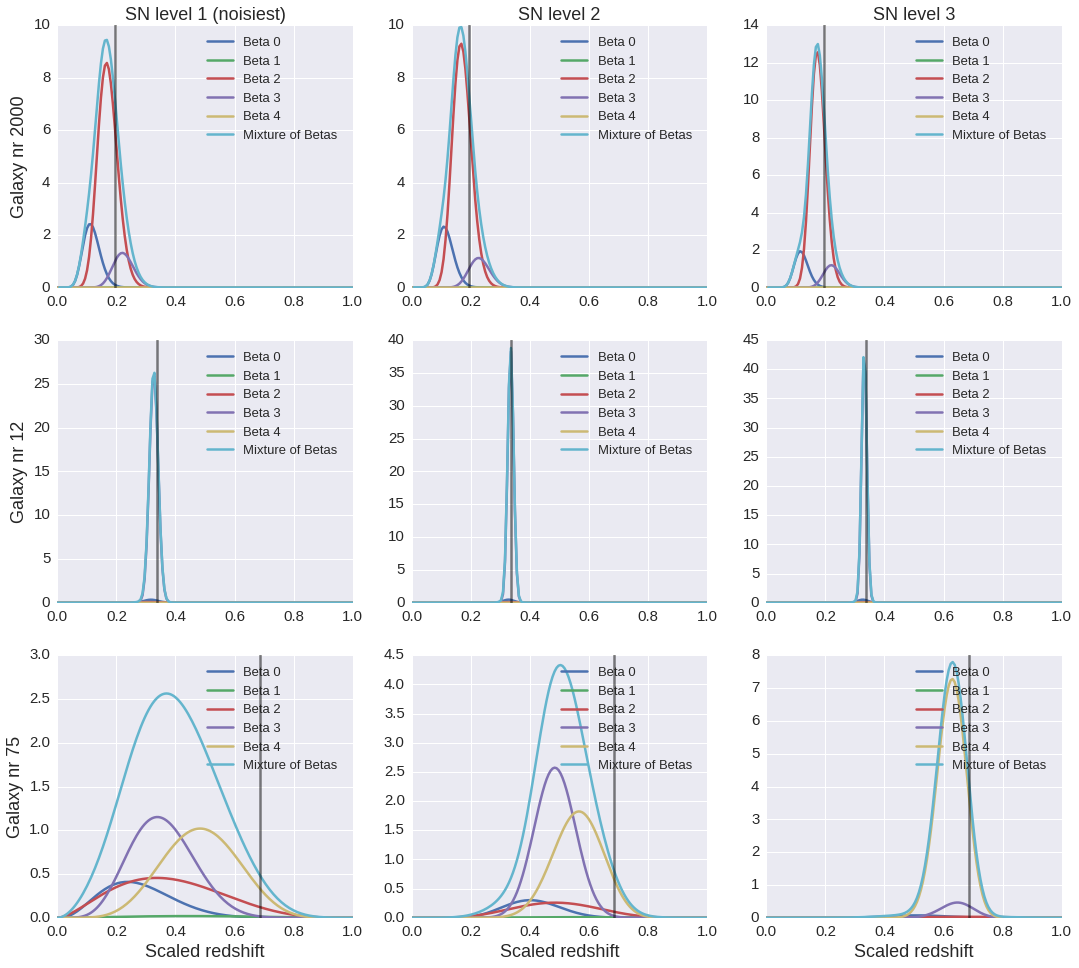

In [14]:
### choose 3 random galaxies ###
gal_id = [2000, 12, 75]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 16))

plot_beta_mix(pi_1[gal_id][0], alpha_1[gal_id][0], beta_1[gal_id][0], axes[0, 0])
plot_beta_mix(pi_2[gal_id][0], alpha_2[gal_id][0], beta_2[gal_id][0], axes[0, 1])
plot_beta_mix(pi_3[gal_id][0], alpha_3[gal_id][0], beta_3[gal_id][0], axes[0, 2])
axes[0, 0].axvline(x=Y_valid[gal_id[0]], color='black', alpha=0.5)
axes[0, 1].axvline(x=Y_valid[gal_id[0]], color='black', alpha=0.5)
axes[0, 2].axvline(x=Y_valid[gal_id[0]], color='black', alpha=0.5)

plot_beta_mix(pi_1[gal_id][1], alpha_1[gal_id][1], beta_1[gal_id][1], axes[1, 0])
plot_beta_mix(pi_2[gal_id][1], alpha_2[gal_id][1], beta_2[gal_id][1], axes[1, 1])
plot_beta_mix(pi_3[gal_id][1], alpha_3[gal_id][1], beta_3[gal_id][1], axes[1, 2])
axes[1, 0].axvline(x=Y_valid[gal_id[1]], color='black', alpha=0.5)
axes[1, 1].axvline(x=Y_valid[gal_id[1]], color='black', alpha=0.5)
axes[1, 2].axvline(x=Y_valid[gal_id[1]], color='black', alpha=0.5)

plot_beta_mix(pi_1[gal_id][2], alpha_1[gal_id][2], beta_1[gal_id][2], axes[2, 0])
plot_beta_mix(pi_2[gal_id][2], alpha_2[gal_id][2], beta_2[gal_id][2], axes[2, 1])
plot_beta_mix(pi_3[gal_id][2], alpha_3[gal_id][2], beta_3[gal_id][2], axes[2, 2])
axes[2, 0].axvline(x=Y_valid[gal_id[2]], color='black', alpha=0.5)
axes[2, 1].axvline(x=Y_valid[gal_id[2]], color='black', alpha=0.5)
axes[2, 2].axvline(x=Y_valid[gal_id[2]], color='black', alpha=0.5)

axes[0, 0].set_ylabel('Galaxy nr ' + str(gal_id[0]), fontsize=18)
axes[1, 0].set_ylabel('Galaxy nr ' + str(gal_id[1]), fontsize=18)
axes[2, 0].set_ylabel('Galaxy nr ' + str(gal_id[2]), fontsize=18)

axes[2, 0].set_xlabel('Scaled redshift', fontsize=18)
axes[2, 1].set_xlabel('Scaled redshift', fontsize=18)
axes[2, 2].set_xlabel('Scaled redshift', fontsize=18)

axes[0, 0].set_title('SN level 1 (noisiest)', fontsize=18)
axes[0, 1].set_title('SN level 2', fontsize=18)
axes[0, 2].set_title('SN level 3', fontsize=18)

The vertical black line is the true redshift. The noisiest observations do indeed have a broader PDF's.
In these galaxies no more that 4 mixtures are needed to describe the PDF. Here no solutions are multimodal, so you will have to take my word for it that in the real universe this does happen.

In the test data set where we kept the truth magnitudes for all noise levels my expectation is that the mean of the distributions will be reasonable good agreement but that the width of PDF differs. 
This due to fact that to first order the most likely location of the galaxy is determined by the magnitudes, and these are exactly the same in this case, but we are in a heteroscedastic noise case so this intuition will probably break down for some cases.

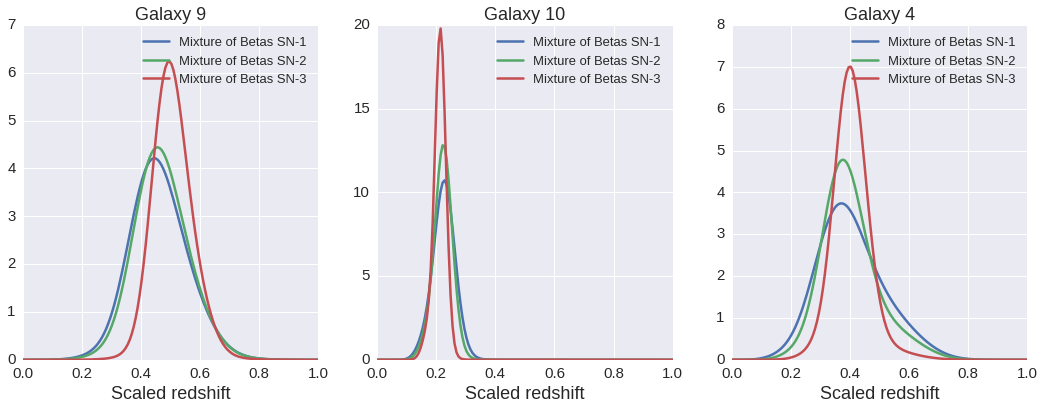

In [15]:
### Plotting the 'artifical' test set where ###
### mag are the same an noise differs ###
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
# lets looks at galaxy 9
gal_id = 9

plot_beta_mix(pi_1_a[gal_id], alpha_1_a[gal_id], beta_1_a[gal_id], 
              axes[0], comp=False, label='SN-1')
plot_beta_mix(pi_2_a[gal_id], alpha_2_a[gal_id], beta_2_a[gal_id], 
              axes[0], comp=False, label='SN-2')
plot_beta_mix(pi_3_a[gal_id], alpha_3_a[gal_id], beta_3_a[gal_id], 
              axes[0], comp=False, label='SN-3')

# lets looks at galaxy 10
gal_id = 10

plot_beta_mix(pi_1_a[gal_id], alpha_1_a[gal_id], beta_1_a[gal_id], 
              axes[1], comp=False, label='SN-1')
plot_beta_mix(pi_2_a[gal_id], alpha_2_a[gal_id], beta_2_a[gal_id], 
              axes[1], comp=False, label='SN-2')
plot_beta_mix(pi_3_a[gal_id], alpha_3_a[gal_id], beta_3_a[gal_id], 
              axes[1], comp=False, label='SN-3')

# lets looks at galaxy 4
gal_id = 4

plot_beta_mix(pi_1_a[gal_id], alpha_1_a[gal_id], beta_1_a[gal_id], 
              axes[2], comp=False, label='SN-1')
plot_beta_mix(pi_2_a[gal_id], alpha_2_a[gal_id], beta_2_a[gal_id], 
              axes[2], comp=False, label='SN-2')
plot_beta_mix(pi_3_a[gal_id], alpha_3_a[gal_id], beta_3_a[gal_id], 
              axes[2], comp=False, label='SN-3')

axes[0].set_xlabel('Scaled redshift', fontsize=18)
axes[1].set_xlabel('Scaled redshift', fontsize=18)
axes[2].set_xlabel('Scaled redshift', fontsize=18)

axes[0].set_title('Galaxy 9', fontsize=18)
axes[1].set_title('Galaxy 10', fontsize=18)
axes[2].set_title('Galaxy 4', fontsize=18)

As you can see, it's a bit of mixed bag, for the right most panel it seems the modes are in reasonable agreement (compared to the uncertainty) but in the first panel the mode of the 3rd signal to noise levels differ from the other two. We would have to do a more thorough analysis to understand the impact of the differing noise to come to any robust conclusions, but it's clear that the heteroscedastic noise properties don't just make the uncertainty larger for noisier galaxies. 

In the next cell we will transform the output of the MDN into a pandas DataFrame for better viewing and while we are at it we will calculate some useful statistics of the PDF. This is a good time to point out some advantages of MDN's over softmax regression (i.e discretizing the regression problem): 

1. The PDF information is contained in 15 numbers per galaxy, If I was doing softmax regression this would depend on the chosen binning. In my case this can be anywhere from 80 to 200 bins, hence using MDN's leads to more efficient data storage, keep in mind we will need this for up to half a billion galaxies. 
2. Some statistics of the PDF can be calculated analytically for the mixture, as we do here for the mean and variance. I don't think this is possible for the mode or entropy. This is useful as we might want to select the galaxies in redshift bins and selecting on the mean is one way of doing this. The mean of the PDF is what we would have gotten if we had minimized the L2 loss functions, if the distribution is multimodal this is of limited use of course.

In [16]:
### return_df is a helper function that 
### returns a pandas DataFrame and also add the
### the mean, stddev and variance of the mixture model
res_1_df = return_df(pi_1, alpha_1, beta_1, Y_valid)
res_2_df = return_df(pi_2, alpha_2, beta_2, Y_valid)
res_3_df = return_df(pi_3, alpha_3, beta_3, Y_valid)

In [17]:
res_1_df.head()

,pi_0,pi_1,pi_2,pi_3,pi_4,alpha_0,alpha_1,alpha_2,alpha_3,alpha_4,beta_0,beta_1,beta_2,beta_3,beta_4,mean,variance,stddev,redshift
0,0.150243,0.001640,0.309851,0.535939,0.002327,13.905331,1.508801,13.924616,24.587959,4.385092,66.174591,4.793630,50.064056,83.770271,4.967509,0.216611,0.000484,0.022003,0.191240
1,0.070490,0.000498,0.043549,0.884710,0.000753,39.536381,1.720022,28.108278,85.484917,8.501275,145.688263,4.844911,96.138847,273.012115,9.095657,0.236355,0.000092,0.009573,0.215803
2,0.103307,0.005261,0.840101,0.038662,0.012669,4.651711,1.009018,8.621865,9.521262,3.975748,31.692495,2.847285,25.707165,23.006001,6.294841,0.241815,0.001809,0.042527,0.220570
3,0.103625,0.000934,0.853936,0.041187,0.000317,28.120638,0.734465,65.802979,43.022697,9.574004,331.073059,3.545668,498.854797,275.509033,5.391367,0.113553,0.000251,0.015855,0.122274
4,0.096823,0.003705,0.141845,0.710211,0.047416,12.417686,2.856616,7.643008,20.916574,7.101041,20.495485,3.929787,11.000093,34.738007,8.502384,0.384737,0.000392,0.019803,0.422067


You might be curious how well are able retrieve the true redshift. 
In the following plot the true redshift is plotted against the estimated redshift for the 3 S/N levels. You can see clearly the quality of the predicted redshifts degrades with higher noise in the data.

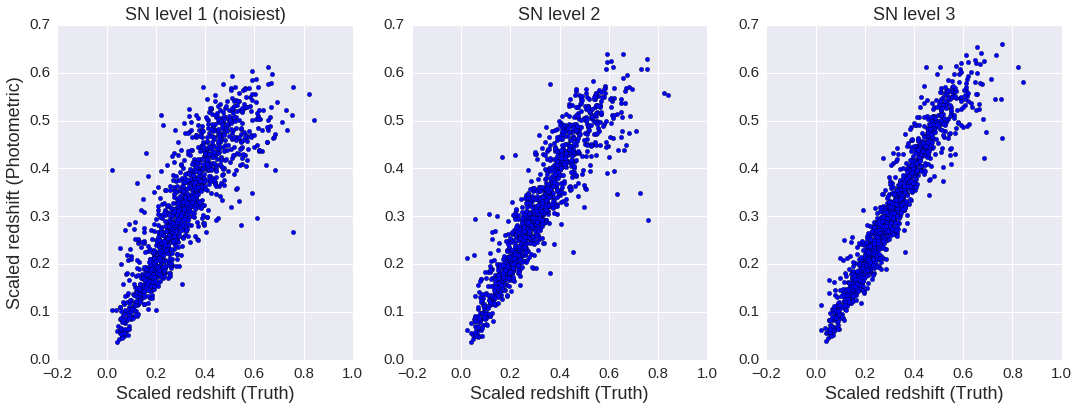

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
amount = 1300

axes[0].scatter(Y_valid[0:amount], res_1_df['mean'].iloc[0:amount])
axes[1].scatter(Y_valid[0:amount], res_2_df['mean'].iloc[0:amount])
axes[2].scatter(Y_valid[0:amount], res_3_df['mean'].iloc[0:amount])

axes[0].set_title('SN level 1 (noisiest)', fontsize=18)
axes[1].set_title('SN level 2', fontsize=18)
axes[2].set_title('SN level 3', fontsize=18)

axes[0].set_xlabel('Scaled redshift (Truth)', fontsize=18)
axes[1].set_xlabel('Scaled redshift (Truth)', fontsize=18)
axes[2].set_xlabel('Scaled redshift (Truth)', fontsize=18)

axes[0].set_ylabel('Scaled redshift (Photometric)', fontsize=18)

Let's have a look if we have managed to learn what we intended to learn. Just to recap, we wanted to learn the distributions of an ensemble of galaxies. The plots below show the estimate distribution in 3 redshift bins by selecting galaxies on the mean of the PDF. The MDN is obtained by stacking the PDF's and the truth is KDE estimate of the true redshifts. 

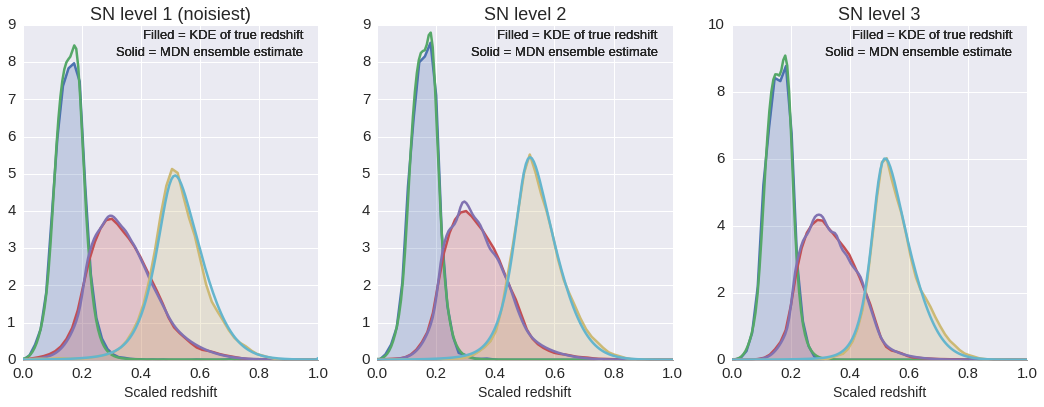

In [19]:
### Keep in mind that the data is mapped on to the domain (0,1)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

### 3 (scaled) redshift bins
redshift_bin_0 = (0.1, 0.2) 
redshift_bin_1 = (0.2, 0.5)
redshift_bin_2 = (0.5, 1.0)

plot_ensemble_multi_process(res_1_df, ax=axes[0], redshift_sel=redshift_bin_0, amount=5000)
plot_ensemble_multi_process(res_1_df, ax=axes[0], redshift_sel=redshift_bin_1, amount=6000)
plot_ensemble_multi_process(res_1_df, ax=axes[0], redshift_sel=redshift_bin_2, amount=10000)

plot_ensemble_multi_process(res_2_df, ax=axes[1], redshift_sel=redshift_bin_0, amount=5000)
plot_ensemble_multi_process(res_2_df, ax=axes[1], redshift_sel=redshift_bin_1, amount=6000)
plot_ensemble_multi_process(res_2_df, ax=axes[1], redshift_sel=redshift_bin_2, amount=10000)

plot_ensemble_multi_process(res_3_df, ax=axes[2], redshift_sel=redshift_bin_0, amount=5000)
plot_ensemble_multi_process(res_3_df, ax=axes[2], redshift_sel=redshift_bin_1, amount=6000)
plot_ensemble_multi_process(res_3_df, ax=axes[2], redshift_sel=redshift_bin_2, amount=10000)

axes[0].set_title('SN level 1 (noisiest)', fontsize=18)
axes[1].set_title('SN level 2', fontsize=18)
axes[2].set_title('SN level 3', fontsize=18)

It seems that the MDN did a pretty good job, Hooray ! It is clear from in the middle redshift bin (red-purple) that noisier simulation leads to wider distributions. 

## Is that all there is to it ?

You might be wondering if this is realistic ? Let me give you some insight into further complications.
In reality the training set is not unbiased sample of the set you are interested in, this is true in (at least) 3 different ways.
1. We are dealing with a co-variate shift, this means that our magnitudes of the training set do not have the same distribution as those of the test set, this can alleviated by incorporating a weighted loss function.
2. There are selection effects in the spectroscopic redshifts. Here is an example: imagine 2 galaxies that have very similar magnitudes, but the spectrograph is unable to determine the redshift of one galaxies due to intrinsic properties of that galaxy and they have different redshift. This means we have a selection effect in the label we want to learn and unless we know that selection effects we are unable to correct for it. Work is being done on understanding these effects but it's not an easy task. Also a small percentage of spectroscopic redshifts are wrong. 
3. The noise properties are unlikely to be fairly sampled given the large range of observing conditions. So it would be useful have a ML method that can extrapolate to different noise models. ML models that do this have been developed in [stellar physics.](http://arxiv.org/abs/1501.07604).
4. Good news: for certain subpopulations these problems are not severe and this method could be applied.

You also might be wondering don't you physicist model everything ? Can't you fit your data to your models. The answer is yes, and we do, it's just that we need to understand galaxy evolution from the Big Bang until now and then we have solved the photometric redshift problem (I'm paraphrasing [Carlos Frenk](https://en.wikipedia.org/wiki/Carlos_Frenk)). Okay, I'm being a bit sarcastic, but you understand what I'm getting at. Some great progress has been made in the literature on [modelling the physics of galaxies](http://arxiv.org/abs/1603.03037) and on using [nice statistical techniques](http://arxiv.org/abs/1602.05960) to infer the redshift distribution.

## Some ML questions you might be able to help me with
0. Using ReLU activation function leads to NaN loss after ~150 iterations, any idea why ? My understanding is that with Adam the gradients shoudln;t blow as easily. 
1. Recently [Yarin Gal](https://twitter.com/yaringal) had a [paper](http://arxiv.org/abs/1506.02142) and a [blog post](http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html) where he states that you can use dropout technique to get uncertainties on the predictions and  that this is a variational approximation to the Gaussian process. How does one interpret this in the case of MDN ? I have yet run the experiment.
2. Speaking of dropout, in initial experiments where I used dropout this occasionally led to NaN loss and hence messed up everything, any particular reason you might know of ? (see point 1.)
3. In the loss functions plots there are some wiggles, can these be interpreted at all ?

## Thanks !
The test data was made by my colleague Francisco Castander!

This blog post is written in a [jupyter notebook](https://github.com/cbonnett/blog/blob/master/content/Mixture%20Density%20Networks%20for%20Galaxy%20distance%20determination%20in%20TensorFlow%20.ipynb) and the data used can be downloaded: [train data](https://drive.google.com/file/d/0B6Mi26c8VkJadFlaVEJObWw3WTg/view?usp=sharing) [test data](https://drive.google.com/file/d/0B6Mi26c8VkJaTE5DVFdZTE9SWmM/view?usp=sharing).

In [ ]:
"""
Helper functions
"""
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta
import multiprocessing as mp
    
def plot_beta_mix(pis, alphas, betas, ax, label='', comp=True):
    """
    Plots the mixture of Beta models to axis=ax
    """
    x = np.linspace(0.0, 1.0, 150)
    final = np.zeros_like(x)
    for i, (weight_mix, alpha_mix, beta_mix) in enumerate(zip(pis, alphas, betas)):
        temp = beta.pdf(x, alpha_mix, beta_mix) * weight_mix
        final = final + temp
        if comp:
            ax.plot(x, temp, label='Beta ' + str(i))
    ax.plot(x, final, label='Mixture of Betas ' + label)
    ax.legend(fontsize=13) 
    

def return_df(pis, alphas, betas, Y_valid):
    """
    Given the output of the MDN, returns
    a DataFrame with mean, variance and stddev added
    """
    pi_names = ['pi_' + str(i) for i in range(len(pis[0]))]
    alpha_names = ['alpha_' + str(i) for i in range(len(pis[0]))]
    beta_names = ['beta_' + str(i) for i in range(len(pis[0]))]
    names = pi_names + alpha_names + beta_names
    temp = np.concatenate((pis, alphas, betas), axis=1)
    df = pd.DataFrame(temp, columns=names)
    
    variances = (alphas * betas)/((alphas * betas)**2.0 *(alphas + betas + 1))
    means = (alphas / (alphas + betas)) 
    
    df['mean'] = np.average(means, weights=pis, axis=1)
    df['variance'] =  np.average(means**2 + variances**2, weights=pis, axis=1) - df['mean'].values**2
    df['stddev'] = np.sqrt(df.variance)
    df['redshift'] = Y_valid
    return df


def plot_ensemble(df, ax=None, redshift_sel=(0, 1.0),  amount=1000):    
    """
    Plots distribtution of ensemble of galaxies 
    estimated by the MDN and the KDE of the truth
    Has nested loop... limited to 1000 samples
    """
    x = np.linspace(0.00001, 0.99999, 150)
    final = np.zeros_like(x)
    
    pi_columns = [s for s in df.columns if "pi_" in s]
    alpha_columns = [s for s in df.columns if "alpha_" in s]
    beta_columns = [s for s in df.columns if "beta_" in s]
    
    sel = ((redshift_sel[0] < df['mean'].values)  &
           (df['mean'].values< redshift_sel[1]))
    if sel.sum() > 0:
    
        df = df[sel].iloc[:amount]

        for _, gal in df.iterrows():        
            for weight_mix, alpha_mix, beta_mix in (zip(gal[pi_columns], gal[alpha_columns] , gal[beta_columns])):
                temp = beta.pdf(x, alpha_mix, beta_mix) * weight_mix
                final = final + temp
        final =  _normalize_pdf(final, x[1] - x[0])
        sns.distplot(df['Redshift'], ax=ax, hist=False, label='KDE of true redshift')
        ax.plot(x, final, label='Ensemble Distribution', linestyle='-')
        if leg:
            ax.legend(fontsize=13)
        ax.set_xlim(0,1.0)
        ax.set_xlabel('Scaled redshift', fontsize=14)
    else:
        print 'No galaxies selected in this redshift bin', redshift_sel
    
def plot_ensemble_multi_process(df, ax=None, redshift_sel=(0, 1.0), amount=1000):
    """
    Plots distribtution of ensemble of galaxies 
    estimated by the MDN and the KDE of the truth
    Multi-process version. Faster, still not fast
    limited to 1000 samples
    """
    pool = mp.Pool(processes=8)
    
    x = np.linspace(0.0001, 0.9999, 150)
    final = np.zeros_like(x)
    
    pi_columns = [s for s in df.columns if "pi_" in s]
    alpha_columns = [s for s in df.columns if "alpha_" in s]
    beta_columns = [s for s in df.columns if "beta_" in s]
    
    sel = ((redshift_sel[0] < df['mean'].values) &
               (df['mean'].values< redshift_sel[1]))

    if sel.sum() > 0:
        df = df[sel].iloc[:amount]

        results = [pool.apply_async(_get_beta, 
                                    args=(x, row[pi_columns], row[alpha_columns], row[beta_columns])) 
                                    for (_, row) in df.iterrows()]
        output = [p.get() for p in results]
        output = np.asarray(output).sum(axis=0)
        final =  _normalize_pdf(output, x[1] - x[0])

        sns.distplot(df['redshift'], ax=ax, hist=False, kde_kws={"shade": True})
        ax.plot(x, final, label='Ensemble Distribution', linestyle='-')
        ax.set_xlim(0, 1.0)
        ax.text(0.95, 0.95, 'Filled = KDE of true redshift',
                verticalalignment='bottom', horizontalalignment='right',
                transform=ax.transAxes, fontsize=13)
        ax.text(0.95, 0.90, 'Solid = MDN ensemble estimate',
                verticalalignment='bottom', horizontalalignment='right',
                transform=ax.transAxes, fontsize=13)
        ax.set_xlabel('Scaled redshift', fontsize=14)

    else:
        print 'No galaxies selected in this redshift bin', redshift_sel
    
def _normalize_pdf(pdf, dz):
    """
    returns normalized pdf
    """
    area = np.trapz(pdf, dx=dz)
    return pdf/np.float(area)


def _get_beta(x, gal_pi, gal_alpha, gal_beta):
    from scipy.stats import beta
    final = np.zeros_like(x)
    for weight_m, alpha_m, beta_m in (zip(gal_pi.values, gal_alpha.values , gal_beta.values)):
        temp = beta.pdf(x, alpha_m, beta_m) * weight_m
        final = final + temp
    return final